# Tutorial

Nangs is a python module built on top of pytorch to solve partial differential equations (PDEs).

## How does it work ?

Let's assume we want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

Different numerical techniques that solve this problem exist, and all of them are based on finding an approximate function that satisfies the PDE. Traditional numerical methods discretize the domain into small elements where a form of the solutions is assumed (for example, a constant) and then the final solution is composed as a piece-wise, discontinuous function.

Nangs uses the property of neural networks (NNs) as universal function approximators to find a continuous and derivable solution to the PDE, that requires significant less computing resources compared with traditional techniques and with the advantage of including the free-parameters as part of the solution.

The independen variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE.

We will see how to do that in this basic tutorial.

## Quick start

Here you can find the code required to solve the above mentioned PDE.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

  0%|          | 0/12 [00:00<?, ?it/s]

cpu


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 0, Loss: 7.596866 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 1, Loss: 0.568185 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 2, Loss: 0.462416 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 3, Loss: 0.401966 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 4, Loss: 0.293196 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 5, Loss: 0.236155 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 6, Loss: 0.203929 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.611681 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.423964 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.348516 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.274323 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.250376 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 12, Loss: 0.182134 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 13, Loss: 0.131566 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 14, Loss: 0.083436 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 15, Loss: 0.053805 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 16, Loss: 0.046613 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.057231 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 18, Loss: 0.035437 


100%|##########| 12/12 [00:00<00:00, 12.20it/s]


Best model, saved !
Epoch: 19, Loss: 0.020083 


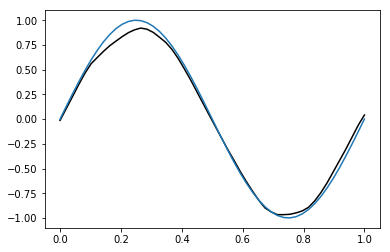

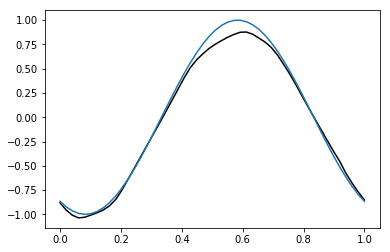

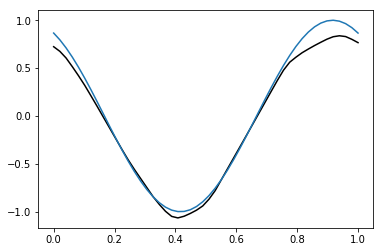

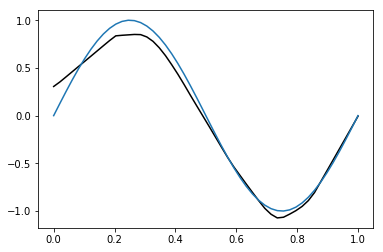

In [2]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = False
device = torch.device("cuda:0" if torch.cuda.is_available() and cuda else "cpu")
print(device)

# import nangs
from nangs import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco

# define custom PDE
class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, params=None):
        super().__init__(inputs, outputs, params)
    def computePdeLoss(self, grads, inputs, params): 
        # here is where the magic happens
        dpdt, dpdx = grads['p']['t'], grads['p']['x']
        u = params['u']
        return dpdt + u*dpdx

# instanciate pde
pde = MyPDE(inputs=['x', 't'], outputs=['p'], params=['u'])

# define input values
x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
u = np.array([1])

pde.setValues({'x': x, 't': t, 'u': u})

# periodic b.c for the space dimension
x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco(pde.inputs, {'x': x1, 't': t}, {'x': x2, 't': t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
p0 = np.sin(2.*math.pi*x)
boco = DirichletBoco(pde.inputs, pde.outputs, {'x': x, 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)

# define solution topology
topo = {'layers': 5, 'neurons': 512, 'activations': 'relu'}
pde.buildModel(topo, device)

# set optimization parameters
pde.setSolverParams(lr=0.01,epochs=20, batch_size=50)

# find the solution
path = 'best_model.pth'
pde.solve(device, path) 

# evaluate the solution
pde.model.load_state_dict(torch.load(path))
x = np.linspace(0,1,50)
t = np.linspace(0,1,4)
for _t in t:
    p0 = np.sin(2.*math.pi*(x-u*_t))
    p = pde.eval({'x': x, 't': np.array([_t])}, device)
    plt.plot(x, p, 'k')
    plt.plot(x, p0)
    plt.show()

## Step by step guide

Let's go through the code step by step. First, we import the nangs module to acces its predefined classes and operations to solve PDEs with NNs.

In [3]:
from nangs import PDE
import torch
cuda = False
device = torch.device("cuda:0" if torch.cuda.is_available() and cuda else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Defining the PDE

Then, we have to instanciate a PDE in order to solve it. We can use a predefined PDE or build our custom one. In this tutorial we are going to solve the one-dimensional advection equation with a custom implementation.

In [4]:
class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, params=None):
        super().__init__(inputs, outputs, params)
    def computePdeLoss(self, grads, inputs, params): 
        # here is where the magic happens
        dpdt, dpdx = grads['p']['t'], grads['p']['x']
        u = params['u']
        return dpdt + u*dpdx

When defining a custom PDE we are required to overwrite the **computePdeLoss** method. This is the function that will be called during the optimization process, and we must ensure that the value returned matches our PDE. If not, we are going to solve a wrong equation.

We build the loss function by combining the derivatives of the NN ouputs w.r.t the inputs and free-parameters in the correct way. Notice that we use keys to retrieve the values ('p' for the output, 'x' and 't' for the inputs and 'u' for the parameter). We must ensure that this keys are created accordingly when the PDE is instanciated.

In [5]:
pde = MyPDE(inputs=['x', 't'], outputs=['p'], params=['u'])
pde.summary()

inputs:  {'x': [], 't': []}
outputs:  {'p': []}
params:  {'u': []}
bocos:  []



We have created two inputs 'x' and 't', an output 'p' and a parameter 'u'. The keys for the different variables must be unique and passed as a list. The order of each key in the list determines the position of the input/output in the corresponding NN layer. 

Different errors may arise when trying to define several inputs/outputs/parameters with the same key

In [6]:
#pde = MyPDE(inputs=['x','x'], outputs=['p'], params=['u'])
#pde = MyPDE(inputs=['t','x'], outputs=['x'], params=['u'])
#pde = MyPDE(inputs=['t','x'], outputs=['p', 'p'], params=['u'])
#pde = MyPDE(inputs=['t','x'], outputs=['p'], params=['p'])
#pde = MyPDE(inputs=['t','x'], outputs=['p'], params=['x'])
pde = MyPDE(inputs=['t','x'], outputs=['p'], params=['u'])
pde.summary()

inputs:  {'x': [], 't': []}
outputs:  {'p': []}
params:  {'u': []}
bocos:  []



At this point we only have declared keys to our variables. In order to solve the PDE we have to specify actual values for all this variables that will be evaluated during the optimization process. We can define this values with the corresponding functions. Values are passed as dictionaries, with the key of the variable and the values as a numpy array of ine dimension. Values for outputs cannot be set.

In [7]:
import numpy as np 

pde = MyPDE(inputs=['x', 't'], outputs=['p'], params=['u'])

# set input values
x = np.array([0, 0.25, 0.5, 0.75, 1.0])
t = np.array([0,0.25, 0.5, 0.75, 1.0])
u = np.array([1])

pde.setValues({'x': x, 't': t, 'u': u})

pde.summary()

inputs:  {'x': array([0.  , 0.25, 0.5 , 0.75, 1.  ]), 't': array([0.  , 0.25, 0.5 , 0.75, 1.  ])}
outputs:  {'p': []}
params:  {'u': array([1])}
bocos:  []



### Defining boundary conditions

We could attempt to start finding the solution at this point, and probably we would find one. Nevertheless that would be a trivial solution since a PDE is constrained by boundary conditions. We can add them as follow.

In [8]:
import math
from nangs.bocos import PeriodicBoco, DirichletBoco

pde = MyPDE(inputs=['x', 't'], outputs=['p'], params=['u'])

x = np.linspace(0, 1, 30)
t = np.linspace(0, 1, 20)
u = np.array([1])

pde.setValues({'x': x, 't': t, 'u': u})

# periodic b.c for the space dimension
x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco(pde.inputs, {'x': x1, 't': t}, {'x': x2, 't': t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
p0 = np.sin(2.*math.pi*x)
boco = DirichletBoco(pde.inputs, pde.outputs, {'x': x, 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)

Boundary conditions must be specified one at a time. Depending on the **type** a different number of parameters are required. 

A PERIODIC boundary condition requires pairs of values that will be enforced to be equal at every step using a mean squared optimization.

A DIRICHLET boundary condition requires a specific value for the outputs that will be matched using a typical mean squared optimization.

### NN topology and optimization parameters

We encode the solution to the PDE using a multi-layer perceptron (MLP).

There are two ways to define the topolgy.

In [9]:
# compact form
topo = {'layers': 3, 'neurons': 64, 'activations': 'relu'}

pde.buildModel(topo, device)

In [10]:
pde.model

Solution(
  (activation): ReLU(inplace)
  (fc_in): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace)
  )
  (fc_hidden): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU(inplace)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU(inplace)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU(inplace)
    )
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

Then, we define our optimization criteria and optimizer. More on this on Pytorch reference guide.

In [11]:
# set optimization parameters
pde.setSolverParams(lr=0.01,epochs=50,batch_size=50)

### Solving the PDE

With everything in place, we can now solve the PDE. We pass the device and the path for saving the best model.

In [12]:
pde.solve(device, 'test_model.pth')

  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 0, Loss: 0.407157 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 1, Loss: 0.282361 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 2, Loss: 0.191466 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 3, Loss: 0.115971 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 4, Loss: 0.074222 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 5, Loss: 0.055216 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 6, Loss: 0.041827 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.052002 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 8, Loss: 0.035684 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 9, Loss: 0.029853 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 10, Loss: 0.026146 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.043081 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.036076 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 13, Loss: 0.022868 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 14, Loss: 0.016573 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.035321 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.019770 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 17, Loss: 0.011500 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 18, Loss: 0.007502 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.039205 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.012675 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 21, Loss: 0.005798 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 22, Loss: 0.003272 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 23, Loss: 0.002170 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 24, Loss: 0.001764 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.015254 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.007656 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.003523 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 28, Loss: 0.001644 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 29, Loss: 0.001135 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 30, Loss: 0.000650 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 31, Loss: 0.000471 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 32, Loss: 0.000356 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.005168 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.009923 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.002941 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.001077 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.000582 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 38, Loss: 0.000302 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 39, Loss: 0.000252 


  0%|          | 0/12 [00:00<?, ?it/s]

Best model, saved !
Epoch: 40, Loss: 0.000236 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.000254 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.001442 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.022262 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.006138 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.002161 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch    46: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 46, Loss: 0.000968 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.000372 


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.000277 


100%|##########| 12/12 [00:00<00:00, 17.79it/s]

Epoch: 49, Loss: 0.000245 


Depending on the problem configuration this will take more or less time. If the loss function does not goes to zero, something is wrong. 

### Evaluate the solution

Once the training is done, we can evaluate our solution.

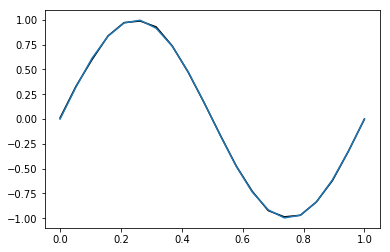

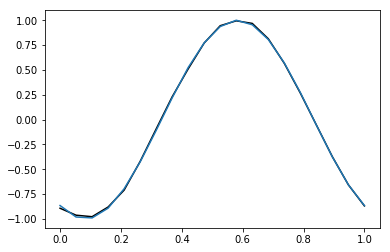

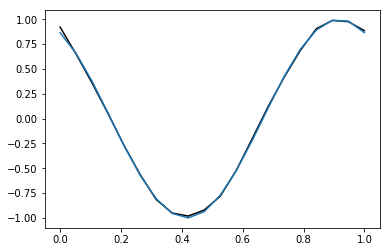

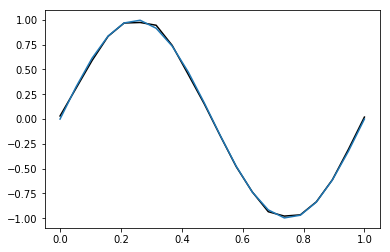

In [13]:
pde.model.load_state_dict(torch.load('test_model.pth'))
x = np.linspace(0,1,20)
t = np.linspace(0,1,4)
for _t in t:
    p0 = np.sin(2.*math.pi*(x-u*_t))
    p = pde.eval({'x': x, 't': np.array([_t])}, device)
    plt.plot(x, p, 'k')
    plt.plot(x, p0)
    plt.show()

### Author

Juan Sensio - juansensio03@gmail.com